In [709]:
import sys
sys.path.append('../src')
sys.path.append('../utils')

import numpy as np
import pandas as pd
from tqdm import notebook as tqdm
import matplotlib.pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
from tslearn.datasets import UCR_UEA_datasets
from tslearn.preprocessing import TimeSeriesScalerMinMax
from tslearn.metrics import dtw

from transformers import AddTime, LeadLag, Dyadic
import iisignature
from tools import *
from sigKer_fast import sig_kernel, sig_distance

In [690]:
def sig_dtw(x,y,depth=2,dyad=3):
    list_x = Dyadic(dyad).fit_transform([x])[0]
    list_y = Dyadic(dyad).fit_transform([y])[0]
    dyad_sig_x = []
    dyad_sig_y = []
    for x_, y_ in zip(list_x, list_y):
        dyad_sig_x.append(iisignature.sig(x_,depth))
        dyad_sig_y.append(iisignature.sig(y_,depth))
    dyad_sig_x = np.array(dyad_sig_x)
    dyad_sig_y = np.array(dyad_sig_y)
#     return dtw(dyad_sig_x, dyad_sig_y)
    return np.sum((dyad_sig_x-dyad_sig_y)**2)

In [755]:
def sig_distance(x,y,n,solver):
    z = np.concatenate([x,y[::-1] - y[-1] + x[-1]])
    return sig_kernel(z,z,n,solver)-1.

In [692]:
def transform(paths, at=False, ll=False):
    if ll:
        paths = LeadLag().fit_transform(paths)
    if at:
        paths = AddTime().fit_transform(paths)
    return paths

In [761]:
data = UCR_UEA_datasets().list_multivariate_datasets()

k = 14
name = data[k]
print(name)

x_train, y_train, x_test, y_test = UCR_UEA_datasets().load_dataset(data[k])

sub_t = 4
sub_nb = 5
sub_nb_ = 5

x_train = x_train[::sub_nb,::sub_t,:]
y_train = y_train[::sub_nb]
x_test = x_test[::sub_nb_,::sub_t,:]
y_test = y_test[::sub_nb_]

print(x_train.shape)
print(x_test.shape)

scale = 0.1
at = False
ll = False
x_train = scale*np.array(transform(x_train, at=at, ll=ll))
x_test = scale*np.array(transform(x_test, at=at, ll=ll))
# l = x_train.shape[1]

Heartbeat
(41, 102, 61)
(41, 102, 61)


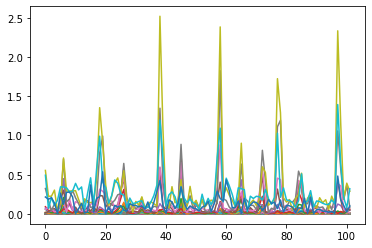

In [762]:
plt.plot(x_train[1])
plt.show()

In [763]:
np.unique(y_train)

array(['abnormal', 'normal'], dtype='<U8')

In [774]:
M,N = x_train.shape[0], x_test.shape[0]
n,solver = 1, 1
depth,dyad = 2, 5

In [775]:
train_matrix_sig = np.zeros((M,M), dtype=np.float64)
train_matrix_dtw = np.zeros((M,M), dtype=np.float64)

test_matrix_sig = np.zeros((N,M), dtype=np.float64)
test_matrix_dtw = np.zeros((N,M), dtype=np.float64)

for i in tqdm.tqdm(range(M)):
    for j in range(M):
#         train_matrix_sig[i,j] = sig_dtw(x_train[i], x_train[j], depth, dyad)
        train_matrix_sig[i,j] = sig_distance(x_train[i], x_train[j], n, solver)
        train_matrix_dtw[i,j] = dtw(x_train[i], x_train[j])
    for k in range(N):
#         test_matrix_sig[k,i] = sig_dtw(x_train[i], x_test[k], depth, dyad)
        test_matrix_sig[k,i] = sig_distance(x_train[i], x_test[k], n, solver)
        test_matrix_dtw[k,i] = dtw(x_train[i], x_test[k])

In [776]:
# train_matrix_sig

In [777]:
clf_sig = KNeighborsClassifier(n_neighbors=1)
clf_sig.fit(train_matrix_sig, y_train)
predictions = clf_sig.predict(test_matrix_sig)
score_sig = accuracy_score(predictions, y_test)
print(score_sig)

0.6585365853658537


In [773]:
clf_dtw = KNeighborsClassifier(n_neighbors=1)
clf_dtw.fit(train_matrix_dtw, y_train)
predictions = clf_dtw.predict(test_matrix_dtw)
score_dtw = accuracy_score(predictions, y_test)
print(score_dtw)

0.6829268292682927


In [384]:
final_results = {}

# standard kernels
for ker in tqdm.tqdm(['linear', 'poly', 'rbf']):
    if ker == 'poly':
        for d in range(2, 5):
            clf = SVC(C=2000, kernel=ker, degree=d, decision_function_shape='ovo', gamma='auto')
            clf.fit([c.reshape(-1) for c in x_train], y_train)
            predictions = clf.predict([c.reshape(-1) for c in x_test])
            final_results[ker + f'-{d}'] = accuracy_score(predictions, y_test)
    else:
        clf = SVC(C=2000, kernel=ker, decision_function_shape='ovo', gamma='auto')
        clf.fit([c.reshape(-1) for c in x_train], y_train)
        predictions = clf.predict([c.reshape(-1) for c in x_test])
        final_results[ker] = accuracy_score(predictions, y_test)
    
# signature naive kernel
clf = SVC(C=2000, kernel='linear', decision_function_shape='ovo', gamma='auto')
for d in tqdm.tqdm(range(1,5)):
    clf.fit([iisignature.sig(c,d) for c in x_train], y_train)
    predictions = clf.predict([iisignature.sig(c,d) for c in x_test])
    final_results[f'sig-naive-{d}'] = accuracy_score(predictions, y_test)

final_results['sig-PDE'] = max(results_penalty)

# Global alignement kernel
# for gamma in tqdm.tqdm([0.0001, 0.001, 0.01, 0.1, 1.]):
#     clf = TimeSeriesSVC(kernel="gak", gamma=gamma)
#     clf.fit(x_train, y_train)
#     final_results[f'GAK-{np.round(gamma,5)}'] = clf.score(x_test, y_test)

In [385]:
final_csv = pd.DataFrame.from_dict(final_results, orient='index').rename(columns={0:'accuracy (%)'})
print(final_csv)
final_csv.to_csv(f'../results/svm-{name}-{np.round(scale,3)}.csv')

             accuracy (%)
linear           0.916667
poly-2           0.283333
poly-3           0.233333
poly-4           0.233333
rbf              0.916667
sig-naive-1      0.633333
sig-naive-2      0.783333
sig-naive-3      0.816667
sig-naive-4      0.833333
sig-PDE          0.883333
